In [84]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [85]:
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [86]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations


In [87]:
session = Session(engine)

## Precipitation Analysis



In [88]:
df = pd.DataFrame(session.query(Measurements.station, Measurements.date, Measurements.prcp, Measurements.tobs).all())
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,0.01,73


In [89]:
# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [100]:
prcp = df[(df.date >= '2011-02-01') & (df.date <= '2012-01-31')].groupby(['date']).sum()
prcp.drop('tobs',inplace=True, axis=1)
prcp.sort_index()
prcp.head()

,prcp
date,
2011-02-01,0.26
2011-02-02,0.02
2011-02-03,0.01
2011-02-04,0.03
2011-02-05,0.00


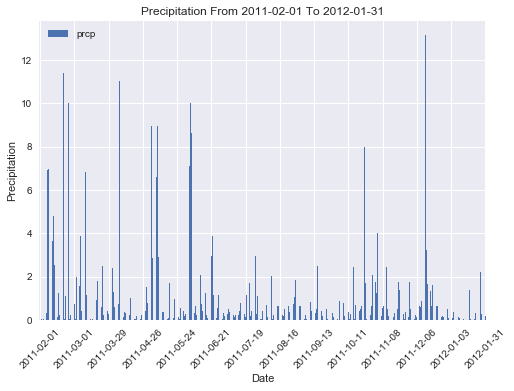

In [101]:
x_axis = np.arange(len(prcp.prcp))
x_lbls = [value for idx, value in enumerate(prcp.index) if idx % 28 == 0]

prcp.plot.bar()
tick_locations = [value + 0.1 for idx, value in enumerate(x_axis) if idx % 28 == 0]
plt.xticks(tick_locations, x_lbls, rotation=45)
plt.title("Precipitation From " + prcp.index[0] + " To " + prcp.index[-1])
plt.xlabel("Date")
plt.ylabel("Precipitation")
sns.set()
plt.savefig('precipitation.png')
plt.show()

## Station Analysis

In [102]:
stations = df.station.unique()
num_stations = len(stations)

In [103]:

# stations and observation counts in descending order
df.groupby('station')['date'].count().sort_values(ascending=False)

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: date, dtype: int64

In [104]:
max_station = 'USC00519281'
station = df[(df.station == max_station) & (df.date >= '2011-02-01') & (df.date <= '2012-01-31') ].groupby(['date']).sum()
station.sort_index()
station.head()

,prcp,tobs
date,,
2011-02-01,0.0,62
2011-02-02,0.0,67
2011-02-03,0.0,68
2011-02-04,0.0,62
2011-02-05,0.0,65


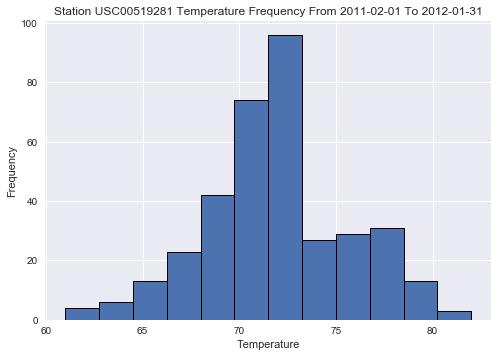

In [105]:
plt.hist(station.tobs, bins=12, edgecolor='black', linewidth='1')
plt.title("Station " + max_station + " Temperature Frequency From " + station.index[0] + " To " + station.index[-1])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
sns.set()
plt.savefig('temperature.png')
plt.show()

## Tempature Analysis

In [106]:
def calc_temps(start_date, end_date):
    temps = df[(df.date >= start_date) & (df.date <= end_date)]
    min_temp = temps.tobs.min()
    max_temp = temps.tobs.max()
    mean_temp = temps.tobs.mean()
    return (min_temp, max_temp, mean_temp)
tmin, tmax, tmean = calc_temps('2011-02-01', '2012-01-31')
tmin, tmax, tmean

(56, 86, 72.80798827409308)

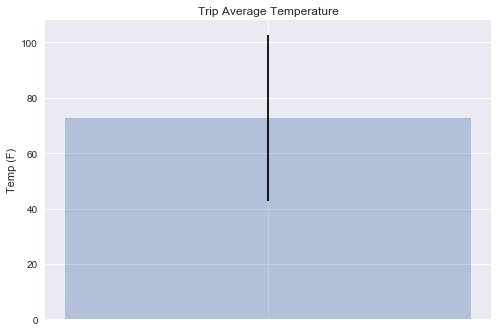

In [108]:
x = ['']
energy = [tmean]
variance = [tmax-tmin]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy,  alpha=.35, yerr=variance)
plt.ylabel("Temp (F)")
plt.title("Trip Average Temperature")

plt.xticks(x_pos, x)
sns.set()
plt.show()
plt.savefig('average_trip_temperature.png')

## Climate App

In [110]:
# /api/v1.0/precipitation
# Query for the dates and temperature observations from the last year.
# Convert the query results to a Dictionary using date as the key and tobs as the value.
# Return the json representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    today = dt.date.today()
    prev_year = today - dt.timedelta(days=365)
    dict = {}
    data = df[(df.date >= str(prev_year)) & (df.date <= str(today))].groupby(['date']).sum()
    for index, row in df.iterrows():
        dict[row.date] = row.prcp
    return jsonify(dict)

In [111]:
# /api/v1.0/stations
# Return a json list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    stations = list(df.station.unique())
    return jsonify(stations)

In [112]:
# /api/v1.0/tobs
# Return a json list of Temperature Observations (tobs) for the previous year
@app.route("/api/v1.0/tobs")
def tobs():
    today = dt.date.today()
    prev_year = today - dt.timedelta(days=365)
    return jsonify(list( int(x) for x in df[(df.date >= str(prev_year)) & (df.date <= str(today))]['tobs']))

In [113]:
# /api/v1.0/<start> and /api/v1.0/<start>/<end>
# Return a json list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end * range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

# http://127.0.0.1:5000/api/v1.0/2011-06-30
@app.route("/api/v1.0/<start>")
def temp_summary_start(start):
    temps = df[(df.date >= start)]
    min_temp = temps.tobs.min()
    max_temp = temps.tobs.max()
    mean_temp = temps.tobs.mean()
    return jsonify({"min_temp": int(min_temp), "max_temp": int(max_temp), "mean_temp": int(mean_temp)})

In [114]:

@app.route("/api/v1.0/<start>/<end>")
def temp_summary_range(start, end):
    temps = df[(df.date >= start) & (df.date <= end)]
    min_temp = temps.tobs.min()
    max_temp = temps.tobs.max()
    mean_temp = temps.tobs.mean()
    return jsonify({"min_temp": int(min_temp), "max_temp": int(max_temp), "mean_temp": int(mean_temp)})

In [116]:

if __name__ == '__main__':
	app.run(debug=False)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Jan/2018 21:46:10] "GET / HTTP/1.1" 404 -
